In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'

Tensorflow version: 2.10.1


In [35]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

# Preprocess training set
train_generator = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

# Preprocess test set
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier

import types


class KerasBatchClassifier(KerasClassifier):

    def fit(self, X, y, **kwargs):

        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit ###################################################
        if self.build_fn is None:
            self.model = self.__call__(**self.filter_sk_params(self.__call__))
        elif not isinstance(self.build_fn, types.FunctionType) and not isinstance(self.build_fn, types.MethodType):
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn.__call__))
        else:
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn))

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__

        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)

        ################################################################################################################
        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        if 'X_val' in kwargs and 'y_val' in kwargs:
            X_val = kwargs['X_val']
            y_val = kwargs['y_val']

            val_gen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True
            )
            val_flow = val_gen.flow(X_val, y_val, batch_size=32)
            val_steps = len(X_val) / 32

            early_stopping = EarlyStopping( patience=5, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", verbose=5, save_best_only=True, mode="auto")
        else:
            val_flow = None
            val_steps = None
            early_stopping = EarlyStopping(monitor="acc", patience=3, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", monitor="acc", verbose=5, save_best_only=True, mode="auto")

        callbacks = [early_stopping, model_checkpoint]

        epochs = self.sk_params['epochs'] if 'epochs' in self.sk_params else 100

        self.__history = self.model.fit_generator(
            datagen.flow(X, y, batch_size=32),  
            steps_per_epoch=len(X) / 32,
            validation_data=val_flow, 
            validation_steps=val_steps, 
            epochs=epochs,
            callbacks=callbacks
        )

        return self.__history

    def score(self, X, y, **kwargs):
        kwargs = self.filter_sk_params(Sequential.evaluate, kwargs)

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__
        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)
        outputs = self.model.evaluate(X, y, **kwargs)
        if type(outputs) is not list:
            outputs = [outputs]
        for name, output in zip(self.model.metrics_names, outputs):
            if name == 'acc':
                return output
        raise Exception('The model is not configured to compute accuracy. '
                        'You should pass `metrics=["accuracy"]` to '
                        'the `model.compile()` method.')

    @property
    def history(self):
        return self.__history

In [32]:
# Grid search for optimal hyperparameters
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

# Define model
def create_model(learning_rate=0.001, dropout_rate=0.0, weight_constraint=0, neurons=64, activation='relu'):
    model = Sequential()
    model.add(Conv2D(64, (3,3), input_shape=(48,48,1), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, (3,3), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(256, (3,3), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding='same', activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(neurons, activation=activation, kernel_constraint=max_norm(weight_constraint)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    model.add(Dense(7, activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create model
experiment_model = KerasClassifier(model=create_model, epochs=10, batch_size=64, verbose=0, activation='relu', dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=0)

# Define hyperparameters
learning_rate = [0.001, 0.01, 0.1]
dropout_rate = [0.1, 0.2]
weight_constraint = [0, 1, 2]
neurons = [64, 128, 256]
activation = ['relu', 'tanh', 'sigmoid']

# Split training set into X and y
(X_train, Y_train) = train_generator.next()

# Define grid search
param_grid = dict(learning_rate=learning_rate, dropout_rate=dropout_rate, weight_constraint=weight_constraint, neurons=neurons, activation=activation)
grid = GridSearchCV(estimator=experiment_model, param_grid=param_grid, n_jobs=1, cv=3, verbose=3)
grid_result = grid.fit(X_train, Y_train)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 1/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=0;, score=0.227 total time=   8.7s
[CV 2/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=0;, score=0.190 total time=   8.7s
[CV 3/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=0;, score=0.143 total time=   8.8s
[CV 1/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=1;, score=0.227 total time=   8.3s
[CV 2/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=1;, score=0.190 total time=   8.9s
[CV 3/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=1;, score=0.286 total time=   9.4s
[CV 1/3] END activation=relu, dropout_rate=0.1, learning_rate=0.001, neurons=64, weight_constraint=2;, score=0.227 total time=   8.8s

In [14]:
print(train_generator.image_shape)

(48, 48, 1)


In [36]:
# Define model
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd convolution layer
model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Flatten and feed into dense layer
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Output layer
model.add(Dense(7, activation='softmax'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_494"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2961 (Conv2D)        (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_3455 (B  (None, 48, 48, 64)       256       
 atchNormalization)                                              
                                                                 
 activation_4 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_1482 (MaxPool  (None, 24, 24, 64)       0         
 ing2D)                                                          
                                                                 
 dropout_1976 (Dropout)      (None, 24, 24, 64)        0         
                                                                 
 conv2d_2962 (Conv2D)        (None, 24, 24, 128)    

In [5]:
# Plots image
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
# Image('model.png',width=400, height=200)

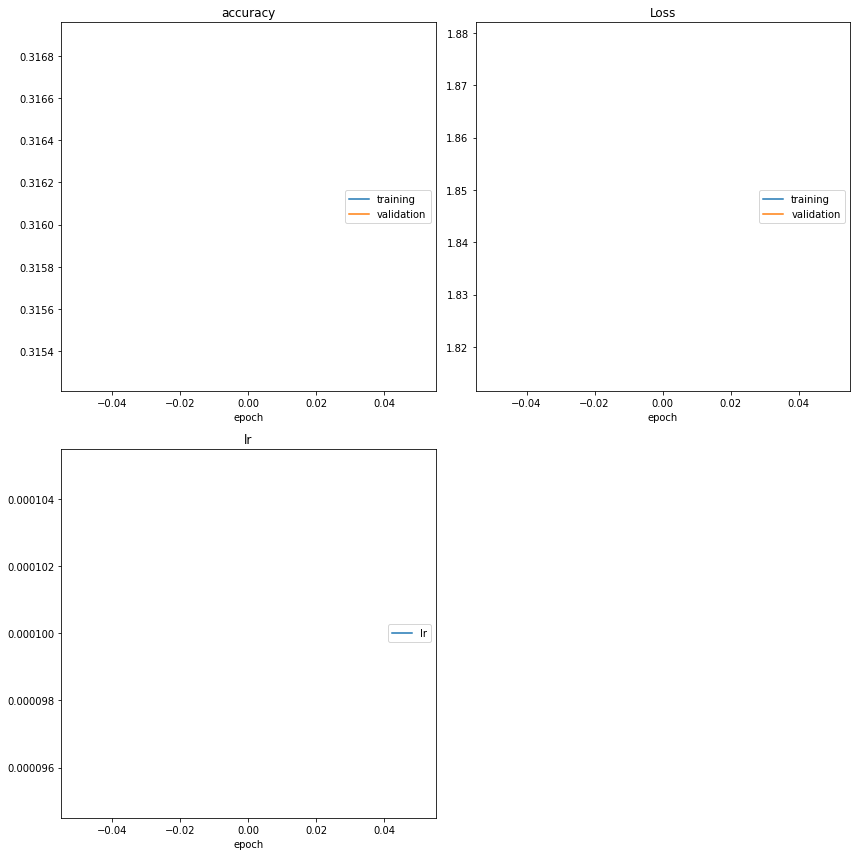

accuracy
	training         	 (min:    0.317, max:    0.317, cur:    0.317)
	validation       	 (min:    0.315, max:    0.315, cur:    0.315)
Loss
	training         	 (min:    1.815, max:    1.815, cur:    1.815)
	validation       	 (min:    1.879, max:    1.879, cur:    1.879)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
448/448 [==============================] - 472s 1s/step - loss: 1.8147 - accuracy: 0.3169 - val_loss: 1.8788 - val_accuracy: 0.3153 - lr: 1.0000e-04
Epoch 2/40
312/448 [===================>..........] - ETA: 2:12 - loss: 1.6141 - accuracy: 0.3830

KeyboardInterrupt: 

In [37]:
# Train model
epochs = 40
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = test_generator.n//test_generator.batch_size

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')

# Save model weights
checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)

# Train model
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, reduce_lr, PlotLossesKeras()],
)

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy.png')
plt.show()